# 과적합 해결

In [98]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets

### 배치 정규화 적용

In [99]:
# 데이터셋 로드
transfrom=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5),(0.5,))])
dataset=datasets.MNIST(root='./data',train=True,transform=transfrom,download=True)

In [100]:
# 데이터 분할
train_size=int(0.8 * len(dataset))
val_size=len(dataset)-train_size

train_data,val_data = random_split(dataset, [train_size,val_size])
train_loader=DataLoader(train_data,batch_size=64,shuffle=True)
val_loader=DataLoader(val_data,batch_size=64,shuffle=False)

In [101]:
class SimpleNN(nn.Module):
    def __init__(self,use_bn=False):
        super(SimpleNN,self).__init__()
        self.fc1=nn.Linear(28*28,128)
        self.bn1=nn.BatchNorm1d(128) if use_bn else nn.Identity()
        self.fc2=nn.Linear(128,64)
        self.bn2=nn.BatchNorm1d(64) if use_bn else nn.Identity()
        self.fc3=nn.Linear(64,10)

    def forward(self,x):
        x=x.view(x.size(0),-1)  # (배치크기, h, w) -> (배치크기, 특성)
        x=torch.relu(self.bn1(self.fc1(x)))
        x=torch.relu(self.bn2(self.fc2(x)))
        x=self.fc3(x)
        return x

In [102]:
def train(model,train_loader,val_loader,epochs=5):
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(model.parameters(),lr=0.001)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images=images.view(images.size(0),-1)
            optimizer.zero_grad()
            outputs=model(images)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
        
        model.eval()
        val_loss=0
        correct=0
        with torch.no_grad():
            for images, labels in val_loader:
                images=images.view(images.size(0),-1)
                outputs=model(images)
                val_loss+=criterion(outputs,labels).item()
                preds=outputs.argmax(dim=1)
                correct+=(preds==labels).sum().item()
        print(f'Epoch {epoch+1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}')

In [137]:
print('배치 정규화 적용 안함')
model_without_bn=SimpleNN(use_bn=False)
train(model_without_bn,train_loader,val_loader)

print('\n배치 정규화 적용')
model_without_bn=SimpleNN(use_bn=True)
train(model_without_bn,train_loader,val_loader)

배치 정규화 적용 안함
Epoch 1 | Val Loss: 0.2674, Accuracy: 0.9216
Epoch 2 | Val Loss: 0.1798, Accuracy: 0.9475
Epoch 3 | Val Loss: 0.1393, Accuracy: 0.9587
Epoch 4 | Val Loss: 0.1324, Accuracy: 0.9628
Epoch 5 | Val Loss: 0.1395, Accuracy: 0.9596

배치 정규화 적용
Epoch 1 | Val Loss: 0.1333, Accuracy: 0.9614
Epoch 2 | Val Loss: 0.1036, Accuracy: 0.9682
Epoch 3 | Val Loss: 0.0958, Accuracy: 0.9700
Epoch 4 | Val Loss: 0.0829, Accuracy: 0.9746
Epoch 5 | Val Loss: 0.0891, Accuracy: 0.9729


In [ ]:
for batch_size in [16,32,128]:
    print(f'batch size : {batch_size}')
    train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
    val_loader=DataLoader(val_data,batch_size=batch_size,shuffle=False)
    model=SimpleNN(use_bn=True)
    train(model,train_loader,val_loader)

batch size : 16
Epoch 1 | Val Loss: 0.1267, Accuracy: 0.9625
Epoch 2 | Val Loss: 0.1163, Accuracy: 0.9630
Epoch 3 | Val Loss: 0.0862, Accuracy: 0.9739
Epoch 4 | Val Loss: 0.0879, Accuracy: 0.9729
Epoch 5 | Val Loss: 0.0803, Accuracy: 0.9758
batch size : 32
Epoch 1 | Val Loss: 0.1222, Accuracy: 0.9608
Epoch 2 | Val Loss: 0.0996, Accuracy: 0.9679
Epoch 3 | Val Loss: 0.0843, Accuracy: 0.9732
Epoch 4 | Val Loss: 0.0762, Accuracy: 0.9768
Epoch 5 | Val Loss: 0.0782, Accuracy: 0.9752
batch size : 128
Epoch 1 | Val Loss: 0.1513, Accuracy: 0.9579
Epoch 2 | Val Loss: 0.1161, Accuracy: 0.9652
Epoch 3 | Val Loss: 0.0925, Accuracy: 0.9714
Epoch 4 | Val Loss: 0.0835, Accuracy: 0.9737
Epoch 5 | Val Loss: 0.0959, Accuracy: 0.9701


# 드롭아웃 적용

In [ ]:
class DropoutNN(nn.Module):
    def __init__(self,dropout_rate):
        super(DropoutNN,self).__init__()
        self.fc1=nn.Linear(28*28,128)
        self.dropout1=nn.Dropout(dropout_rate)
        self.fc2=nn.Linear(128,64)
        self.dropout2=nn.Dropout(dropout_rate)
        self.fc3=nn.Linear(64,10)

    def forward(self,x):
        x=x.view(x.size(0),-1)  # (배치크기, h, w) -> (배치크기, 특성)
        x=torch.relu(self.dropout1(self.fc1(x)))
        x=torch.relu(self.dropout2(self.fc2(x)))
        x=self.fc3(x)
        return x
        

In [ ]:
train_loader=DataLoader(train_data,batch_size=64,shuffle=True)
val_loader=DataLoader(val_data,batch_size=64,shuffle=False)

for rate in [0.2,0.5,0.8]:
    print(f'Drop Rate: {rate}')
    model=DropoutNN(dropout_rate=rate)
    train(model,train_loader,val_loader)

Drop Rate: 0.2
Epoch 1 | Val Loss: 0.2736, Accuracy: 0.9155
Epoch 2 | Val Loss: 0.2193, Accuracy: 0.9332
Epoch 3 | Val Loss: 0.1648, Accuracy: 0.9480
Epoch 4 | Val Loss: 0.1409, Accuracy: 0.9567
Epoch 5 | Val Loss: 0.1515, Accuracy: 0.9523
Drop Rate: 0.5
Epoch 1 | Val Loss: 0.3481, Accuracy: 0.8963
Epoch 2 | Val Loss: 0.2897, Accuracy: 0.9127
Epoch 3 | Val Loss: 0.2692, Accuracy: 0.9173
Epoch 4 | Val Loss: 0.2408, Accuracy: 0.9268
Epoch 5 | Val Loss: 0.2190, Accuracy: 0.9333
Drop Rate: 0.8
Epoch 1 | Val Loss: 1.6769, Accuracy: 0.5326
Epoch 2 | Val Loss: 1.6358, Accuracy: 0.5630
Epoch 3 | Val Loss: 1.6587, Accuracy: 0.4962
Epoch 4 | Val Loss: 1.6149, Accuracy: 0.5657
Epoch 5 | Val Loss: 1.6011, Accuracy: 0.5348


- 훈련시 드롭아웃 활성화, 테스트 시 비활성화

In [ ]:
def train_do(model,train_loader,val_loader,epochs=5):
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(model.parameters(),lr=0.001)

    for epoch in range(epochs):
        for images, labels in train_loader:
            images=images.view(images.size(0),-1)
            optimizer.zero_grad()
            outputs=model(images)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
        
        val_loss=0
        correct=0
        with torch.no_grad():
            for images, labels in val_loader:
                images=images.view(images.size(0),-1)
                outputs=model(images)
                val_loss+=criterion(outputs,labels).item()
                preds=outputs.argmax(dim=1)
                correct+=(preds==labels).sum().item()
        print(f'Epoch {epoch+1} | Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}')

In [ ]:
model= DropoutNN(dropout_rate=0.3)

# train 모드 == 드롭아웃 활성화
model.train()
train_do(model,train_loader,val_loader)

print()

# eval 모드 == 드롭아웃 활성화
model.eval()
train_do(model,train_loader,val_loader)

Epoch 1 | Val Loss: 0.3852, Accuracy: 0.8872
Epoch 2 | Val Loss: 0.3243, Accuracy: 0.9068
Epoch 3 | Val Loss: 0.3169, Accuracy: 0.9047
Epoch 4 | Val Loss: 0.2746, Accuracy: 0.9190
Epoch 5 | Val Loss: 0.2799, Accuracy: 0.9187

Epoch 1 | Val Loss: 0.1301, Accuracy: 0.9621
Epoch 2 | Val Loss: 0.1377, Accuracy: 0.9569
Epoch 3 | Val Loss: 0.1183, Accuracy: 0.9653
Epoch 4 | Val Loss: 0.1065, Accuracy: 0.9690
Epoch 5 | Val Loss: 0.1053, Accuracy: 0.9696


# Learning Rate Schduler 적용

In [ ]:
class RealSimpleNN(nn.Module):
    def __init__(self):
        super(RealSimpleNN,self).__init__()
        self.fc1=nn.Linear(28*28,128)
        self.fc2=nn.Linear(128,64)
        self.fc3=nn.Linear(64,10)

    def forward(self,x):
        x=x.view(x.size(0),-1)
        x=torch.relu(self.fc1(x))
        x=torch.relu(self.fc2(x))
        x=self.fc3(x)
        return x

In [ ]:
def train_lr(model,train_loader,val_loader,optimizer,scheduler,epochs=10):
    criterion=nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images=images.view(images.size(0),-1)
            optimizer.zero_grad()
            outputs=model(images)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()

        model.eval()
        val_loss=0
        correct=0
        with torch.no_grad():
            for images, labels in val_loader:
                images=images.view(images.size(0),-1)
                outputs=model(images)
                val_loss+=criterion(outputs,labels).item()
                preds=outputs.argmax(dim=1)
                correct+=(preds==labels).sum().item()
        
        scheduler.step()
        print(f'Epoch {epoch+1}| Val Loss: {val_loss/len(val_loader):.4f}, Accuracy: {correct/len(val_data):.4f}, LearningRate: {scheduler.get_last_lr()[0]}')

In [ ]:
model=RealSimpleNN()
optimizer=optim.Adam(model.parameters(),lr=0.01)
scheduler=optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)

train_lr(model,train_loader,val_loader,optimizer,scheduler)

Epoch 1| Val Loss: 0.2520, Accuracy: 0.9248, LearningRate: 0.01
Epoch 2| Val Loss: 0.2819, Accuracy: 0.9186, LearningRate: 0.01
Epoch 3| Val Loss: 0.2088, Accuracy: 0.9428, LearningRate: 0.001
Epoch 4| Val Loss: 0.1500, Accuracy: 0.9561, LearningRate: 0.001
Epoch 5| Val Loss: 0.1470, Accuracy: 0.9565, LearningRate: 0.001
Epoch 6| Val Loss: 0.1392, Accuracy: 0.9590, LearningRate: 0.0001
Epoch 7| Val Loss: 0.1344, Accuracy: 0.9594, LearningRate: 0.0001
Epoch 8| Val Loss: 0.1333, Accuracy: 0.9607, LearningRate: 0.0001
Epoch 9| Val Loss: 0.1335, Accuracy: 0.9613, LearningRate: 1e-05
Epoch 10| Val Loss: 0.1331, Accuracy: 0.9613, LearningRate: 1e-05


### 조기 종료 적용

In [120]:
def train_es(model, train_loader, val_loader, optimizer, epochs=50, early_stopping=None):
    criterion=nn.CrossEntropyLoss()
    train_losses=[]
    val_losses=[]

    for epoch in range(epochs):
        model.train()
        train_loss=0
        for images, labels in train_loader:
            images= images.view(images.size(0),-1)
            optimizer.zero_grad()
            outputs=model(images)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss/=len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss=0
        correct=0
        with torch.no_grad():
            for images, labels in val_loader:
                images=images.view(images.size(0),-1)
                outputs =model(images)
                loss=criterion(outputs, labels)
                val_loss += loss.item()
                preds= outputs.argmax(dim=1)
                correct+=(preds==labels).sum().item()
            
        val_loss/=len(val_loader)
        val_losses.append(val_loss)
        accuracy=correct/len(val_data)

        print(f'Epoch {epoch+1} | Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        if early_stopping and early_stopping(val_loss):
            print(f'조기종료 epoch {epoch+1}')
            break
    return train_losses, val_losses

In [121]:
class EarlyStopping:
    def __init__(self,patience=5,min_delta=0.001):
        self.patience = patience
        self.min_delta=min_delta
        self.best_loss=float('inf')
        self.counter=0

    def __call__(self,val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss=val_loss
            self.count=0
        else:
            self.counter+=1

        return self.counter>=self.patience

In [122]:
model_no_es=RealSimpleNN()
optim_no_es = optim.Adam(model_no_es.parameters(), lr=0.01)
train_losses,val_losses=train_es(model_no_es,train_loader,val_loader,optim_no_es)

print('\n|Early Stopping|')
model_es=RealSimpleNN()
optim_es=optim.Adam(model_es.parameters(),lr=0.01)
early_stopping=EarlyStopping(patience=5)
train_es_losses,val_es_losses=train_es(model_es,train_loader,val_loader,optim_es,early_stopping=early_stopping)

Epoch 1 | Loss: 0.3054, Accuracy: 0.9058
Epoch 2 | Loss: 0.2366, Accuracy: 0.9304
Epoch 3 | Loss: 0.2293, Accuracy: 0.9360
Epoch 4 | Loss: 0.3083, Accuracy: 0.9208
Epoch 5 | Loss: 0.2152, Accuracy: 0.9447
Epoch 6 | Loss: 0.2825, Accuracy: 0.9283
Epoch 7 | Loss: 0.2508, Accuracy: 0.9373
Epoch 8 | Loss: 0.1890, Accuracy: 0.9539
Epoch 9 | Loss: 0.2266, Accuracy: 0.9431
Epoch 10 | Loss: 0.2365, Accuracy: 0.9445
Epoch 11 | Loss: 0.2056, Accuracy: 0.9519
Epoch 12 | Loss: 0.2110, Accuracy: 0.9489
Epoch 13 | Loss: 0.1852, Accuracy: 0.9550
Epoch 14 | Loss: 0.2168, Accuracy: 0.9486
Epoch 15 | Loss: 0.1865, Accuracy: 0.9557
Epoch 16 | Loss: 0.2076, Accuracy: 0.9497
Epoch 17 | Loss: 0.2422, Accuracy: 0.9446
Epoch 18 | Loss: 0.2803, Accuracy: 0.9425
Epoch 19 | Loss: 0.2667, Accuracy: 0.9390
Epoch 20 | Loss: 0.2876, Accuracy: 0.9426
Epoch 21 | Loss: 0.2360, Accuracy: 0.9473
Epoch 22 | Loss: 0.2389, Accuracy: 0.9513
Epoch 23 | Loss: 0.2064, Accuracy: 0.9594
Epoch 24 | Loss: 0.2189, Accuracy: 0.9547
E

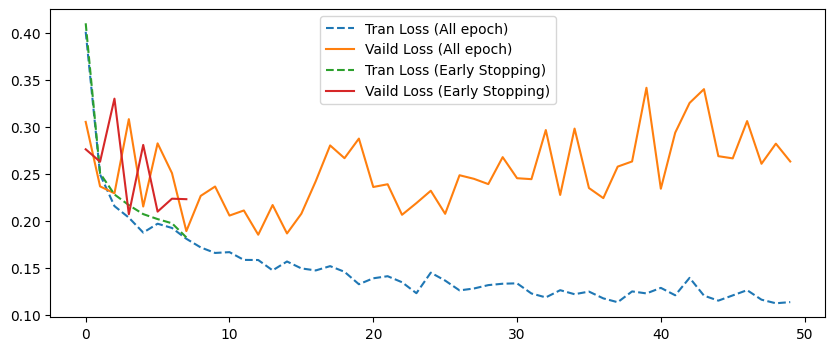

In [123]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(train_losses,label='Tran Loss (All epoch)', linestyle='dashed')
plt.plot(val_losses,label='Vaild Loss (All epoch)')
plt.plot(train_es_losses,label='Tran Loss (Early Stopping)', linestyle='dashed')
plt.plot(val_es_losses,label='Vaild Loss (Early Stopping)')

plt.legend()
plt.show()

# L1, L2 적용

In [ ]:
def train_reg(model, train_loader, val_loader, optimizer, epochs=50, early_stopping=None):
    criterion=nn.CrossEntropyLoss()
    train_losses=[]
    val_losses=[]
    weight_norms=[]

    for epoch in range(epochs):
        model.train()
        train_loss=0
        for images, labels in train_loader:
            images= images.view(images.size(0),-1)
            optimizer.zero_grad()
            outputs=model(images)
            loss=criterion(outputs,labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss/=len(train_loader)
        train_losses.append(train_loss)

        model.eval()
        val_loss=0
        correct=0
        with torch.no_grad():
            for images, labels in val_loader:
                images=images.view(images.size(0),-1)
                outputs =model(images)
                loss=criterion(outputs, labels)
                val_loss += loss.item()
                preds= outputs.argmax(dim=1)
                correct+=(preds==labels).sum().item()

        val_loss/=len(val_loader)
        val_losses.append(val_loss)
        accuracy=correct/len(val_data)

        print(f'Epoch {epoch+1} | Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

        weight_norm=sum(torch.norm(p).item() for p in model.parameters())
        weight_norms.append(weight_norm)

    return train_losses, val_losses, weight_norms

In [ ]:
model_no_reg = RealSimpleNN()
optim_no_reg = optim.SGD(model_no_reg.parameters(), lr=0.01, weight_decay=0.0, momentum=0.9)
train_losses, val_losses,weight_norms = train_reg(model_no_reg, train_loader, val_loader, optim_no_reg)

model_reg = RealSimpleNN()
optim_reg = optim.SGD(model_reg.parameters(), lr=0.01, weight_decay=0.01, momentum=0.9)
train_reg_losses, val_reg_losses,weight_norms_reg = train_reg(model_reg, train_loader, val_loader, optim_reg)

Epoch 1 | Loss: 0.2647, Accuracy: 0.9194
Epoch 2 | Loss: 0.1788, Accuracy: 0.9462
Epoch 3 | Loss: 0.1459, Accuracy: 0.9557
Epoch 4 | Loss: 0.1320, Accuracy: 0.9587
Epoch 5 | Loss: 0.1289, Accuracy: 0.9621
Epoch 6 | Loss: 0.1246, Accuracy: 0.9633
Epoch 7 | Loss: 0.1408, Accuracy: 0.9587
Epoch 8 | Loss: 0.1154, Accuracy: 0.9667
Epoch 9 | Loss: 0.1092, Accuracy: 0.9694
Epoch 10 | Loss: 0.0999, Accuracy: 0.9702
Epoch 11 | Loss: 0.1027, Accuracy: 0.9696
Epoch 12 | Loss: 0.1158, Accuracy: 0.9683
Epoch 13 | Loss: 0.0995, Accuracy: 0.9728
Epoch 14 | Loss: 0.1091, Accuracy: 0.9706
Epoch 15 | Loss: 0.1069, Accuracy: 0.9732
Epoch 16 | Loss: 0.0971, Accuracy: 0.9739
Epoch 17 | Loss: 0.1225, Accuracy: 0.9701
Epoch 18 | Loss: 0.1121, Accuracy: 0.9733
Epoch 19 | Loss: 0.1185, Accuracy: 0.9695
Epoch 20 | Loss: 0.1142, Accuracy: 0.9713
Epoch 21 | Loss: 0.1014, Accuracy: 0.9748
Epoch 22 | Loss: 0.1218, Accuracy: 0.9724
Epoch 23 | Loss: 0.1187, Accuracy: 0.9743
Epoch 24 | Loss: 0.1218, Accuracy: 0.9736
E

KeyboardInterrupt: 

In [ ]:
plt.fugure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(train_losses,label='Train Loss (No Reg)',linestyle='dashed')
plt.plot(val_losses,label='Vaild Loss (No Reg)')
plt.plot(train_losses,label='Train Loss (L2 Reg)',linestyle='dashed')
plt.plot(val_losses,label='Vaild Loss (L2 Reg)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(weight_norms,labeld='Weight Norm (No Reg)')
plt.plot(weight_norms_reg,labeld='Weight Norm (L2 Reg)')
plt.xlabel('Epoch')
plt.ylabel('Weight Norm')
plt.legend()

plt.show()